## Inclusile classifier model performance metrics with tf.Keras using data in TFRecord format

This notebook loads a trained model for the dense neural network using the Inclusive Classifier.
This uses as input the list of particles + the High Level Features. Data is prepared from Parquet using Apache Spark, into TFRecord format and used with tf.Data and tf.io in tf.keras.
Training is done in a separate notebook and/or distributed code.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 2.0.0-beta1
* *Platform*: CentOS 7, Python 3.6

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

tf.version.VERSION
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

'2.0.0-beta1'

# Load the trained model

In [3]:
model_path = "/local1/lucatests/SparkDLTrigger/Training_TFKeras_Distributed/model/mymodel0.h5"

model = tf.keras.models.load_model(model_path)

W0820 09:41:44.687826 140502517139264 deprecation.py:323] From /local1/lucatests/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3868: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Load test data in TFRecord format, using tf.data and tf.io

In [5]:
# test dataset 
PATH = "/local3/lucatests/Data/testUndersampled.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r-*")
#files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r-0000*")

In [6]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [8]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
# Show and example of the parsed data
for record in parsed_test_dataset.take(1):
    print(record)

((<tf.Tensor: id=2554, shape=(801, 19), dtype=float32, numpy=
array([[ 2.7679362e+00, -6.6986263e-01,  4.1799945e-01, ...,
         0.0000000e+00, -3.5355341e-02,  1.1706521e-02],
       [ 2.4898300e+00, -3.4988403e-01,  7.5574207e-01, ...,
         0.0000000e+00, -3.5355341e-02,  1.1706521e-02],
       [ 2.7617359e+00, -7.4597275e-01,  7.7130169e-01, ...,
         0.0000000e+00, -3.5355341e-02,  1.1706521e-02],
       ...,
       [-3.4480712e-01,  1.1782587e+00, -1.4061759e+00, ...,
         0.0000000e+00, -3.5355341e-02,  1.5745270e+00],
       [-4.5961645e-01,  2.8381309e-01, -3.0532807e-01, ...,
         0.0000000e+00, -3.5355341e-02, -1.5511140e+00],
       [ 1.4852233e+00,  1.6163239e+01, -1.9349213e+01, ...,
         0.0000000e+00,  2.8284271e+01, -1.5511140e+00]], dtype=float32)>, <tf.Tensor: id=2555, shape=(14,), dtype=float32, numpy=
array([9.1858739e-03, 3.0343675e-03, 8.0878448e-01, 6.5038260e-04,
       6.6666670e-02, 1.2500000e-01, 9.5962994e-03, 4.5117339e-01,
       3.6

In [10]:
# tunable
test_batch_size = 1024 

test=parsed_test_dataset.batch(test_batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [11]:
num_test_samples=856090 # there are 856090 samples in the test dataset

validation_steps=num_test_samples//test_batch_size  
validation_steps

836

## Confusion Matrix

In [12]:
%time y_pred = model.predict(test, steps=validation_steps)
num_entries=y_pred[:,0].size

CPU times: user 1h 8min 42s, sys: 59min 30s, total: 2h 8min 12s
Wall time: 26min 12s


In [13]:
%time y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

CPU times: user 4min 1s, sys: 42.1 s, total: 4min 43s
Wall time: 2min 20s


In [14]:
y_true = np.stack(y_test_all[:num_entries])

In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9582


<IPython.core.display.Javascript object>


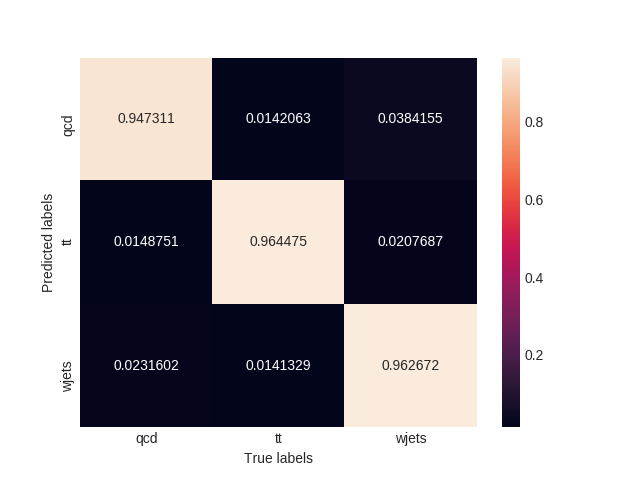

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Example test data and data predicted by the model

In [17]:
y_pred[:4]

array([[9.9499315e-01, 4.1504195e-03, 8.5651031e-04],
       [9.9970466e-01, 2.2941107e-04, 6.5890803e-05],
       [3.6251087e-02, 9.1728026e-01, 4.6468664e-02],
       [8.0323586e-04, 4.3817860e-04, 9.9875855e-01]], dtype=float32)

In [18]:
y_true[:4]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

## ROC and AUC

In [19]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [20]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.995355033277009, 1: 0.9970312872562305, 2: 0.9949794446408011}

<IPython.core.display.Javascript object>


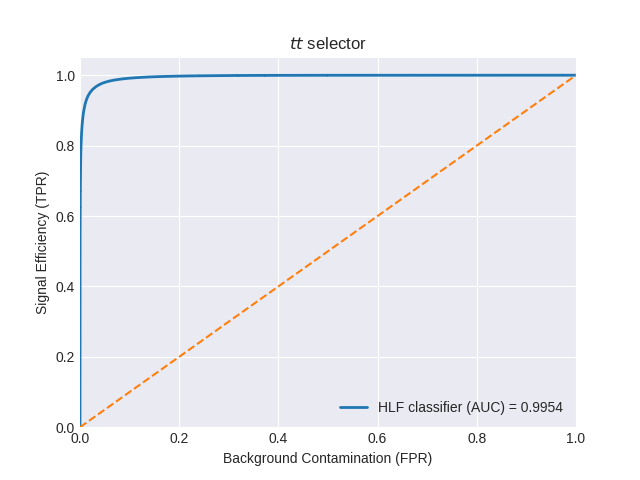

In [21]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()